<!--- Licensed to the Apache Software Foundation (ASF) under one -->
<!--- or more contributor license agreements.  See the NOTICE file -->
<!--- distributed with this work for additional information -->
<!--- regarding copyright ownership.  The ASF licenses this file -->
<!--- to you under the Apache License, Version 2.0 (the -->
<!--- "License"); you may not use this file except in compliance -->
<!--- with the License.  You may obtain a copy of the License at -->

<!---   http://www.apache.org/licenses/LICENSE-2.0 -->

<!--- Unless required by applicable law or agreed to in writing, -->
<!--- software distributed under the License is distributed on an -->
<!--- "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY -->
<!--- KIND, either express or implied.  See the License for the -->
<!--- specific language governing permissions and limitations -->
<!--- under the License. -->

# Step 6: Train a Neural Network

Now that you have seen all the necessary components for creating a neural network, you are
now ready to put all the pieces together and train a model end to end.

## 1. Data preparation

The typical process for creating and training a model starts with loading and
preparing the datasets. For this Network you will use a [dataset of leaf
images](https://data.mendeley.com/datasets/hb74ynkjcn/1) that consists of healthy
and diseased examples of leafs from twelve different plant species. To get this
dataset you have to download and extract it with the following commands.

In [1]:
# Import all the necessary libraries to train
import time
import os
import zipfile

import mxnet as mx
from mxnet import np, npx, gluon, init, autograd
from mxnet.gluon import nn
from mxnet.gluon.data.vision import transforms

import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import numpy as np

from prepare_dataset import process_dataset #utility code to rearrange the data

mx.np.random.seed(42)

In [2]:
# Download dataset
url = 'https://md-datasets-cache-zipfiles-prod.s3.eu-west-1.amazonaws.com/hb74ynkjcn-1.zip'
zip_file_path = mx.gluon.utils.download(url)

os.makedirs('plants', exist_ok=True)

with zipfile.ZipFile(zip_file_path, 'r') as zf:
    zf.extractall('plants')

os.remove(zip_file_path)

#### Data inspection

If you take a look at the dataset you find the following structure for the directories:

```
plants
|-- Alstonia Scholaris (P2)
|-- Arjun (P1)
|-- Bael (P4)
    |-- diseased
        |-- 0016_0001.JPG
        |-- .
        |-- .
        |-- .
        |-- 0016_0118.JPG
|-- .
|-- .
|-- .
|-- Mango (P0)
    |-- diseased
    |-- healthy
```


Each plant species has its own directory, for each of those directories you might
find subdirectories with examples of diseased leaves, healthy
leaves, or both. With this dataset you can formulate different classification
problems; for example, you can create a multi-class classifier that determines
the species of a plant based on the leaves; you can instead create a binary
classifier that tells you whether the plant is healthy or diseased. Additionally, you can create
a multi-class, multi-label classifier that tells you both: what species a
plant is and whether the plant is diseased or healthy. In this example you will stick to
the simplest classification question, which is whether a plant is healthy or not.

To do this, you need to manipulate the dataset in two ways. First, you need to
combine all images with labels consisting of healthy and diseased, regardless of the species, and then you
need to split the data into train, validation, and test sets. We prepared a
small utility script that does this to get the dataset ready for you.
Once you run this utility code on the data, the structure will be
already organized in folders containing the right images in each of the classes,
you can use the `ImageFolderDataset` class to import the images from the file to MXNet.

In [3]:
# Call the utility function to rearrange the images
process_dataset('plants')

The dataset is located in the `datasets` folder and the new structure
looks like this:

```
datasets
|-- test
    |-- diseased
    |-- healthy
|-- train
|-- validation
    |-- diseased
    |-- healthy
        |-- image1.JPG
        |-- image2.JPG
        |-- .
        |-- .
        |-- .
        |-- imagen.JPG
```


Now, you need to create three different Dataset objects from the `train`,
`validation`, and `test` folders, and the `ImageFolderDataset` class takes
care of inferring the classes from the directory names. If you don't remember
how the `ImageFolderDataset` works, take a look at [Step 5](5-datasets.md)
of this course for a deeper description.

In [4]:
# Use ImageFolderDataset to create a Dataset object from directory structure
train_dataset = gluon.data.vision.ImageFolderDataset('./datasets/train')
val_dataset = gluon.data.vision.ImageFolderDataset('./datasets/validation')
test_dataset = gluon.data.vision.ImageFolderDataset('./datasets/test')

The result from this operation is a different Dataset object for each folder.
These objects hold a collection of images and labels and as such they can be
indexed, to get the $i$-th element from the dataset. The $i$-th element is a
tuple with two objects, the first object of the tuple is the image in array
form and the second is the corresponding label for that image.

[15:13:22] /work/mxnet/src/storage/storage.cc:202: Using Pooled (Naive) StorageManager for CPU


Data type: uint8
Label: 0
Label description: diseased
Image shape: (4000, 6000, 3)


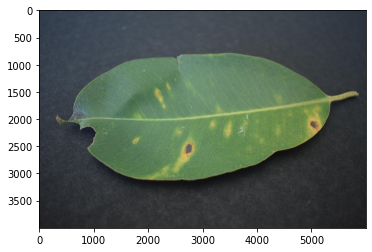

In [5]:
sample_idx = 888 # choose a random sample
sample = train_dataset[sample_idx]
data = sample[0]
label = sample[1]

plt.imshow(data.asnumpy())
print(f"Data type: {data.dtype}")
print(f"Label: {label}")
print(f"Label description: {train_dataset.synsets[label]}")
print(f"Image shape: {data.shape}")

As you can see from the plot, the image size is very large 4000 x 6000 pixels.
Usually, you downsize images before passing them to a neural network to reduce the training time.
It is also customary to make slight modifications to the images to improve generalization. That is why you add
transformations to the data in a process called Data Augmentation.

You can augment data in MXNet using `transforms`. For a complete list of all
the available transformations in MXNet check out
[available transforms](../../../api/gluon/data/vision/transforms/index.rst).
It is very common to use more than one transform per image, and it is also
common to process transforms sequentially. To this end, you can use the `transforms.Compose` class.
This class is very useful to create a transformation pipeline for your images.

You have to compose two different transformation pipelines, one for training
and the other one for validating and testing. This is because each pipeline
serves different pursposes. You need to downsize, convert to tensor and normalize
images across all the different datsets; however, you typically do not want to randomly flip
or add color jitter to the validation or test images since you could reduce performance.

In [6]:
# Import transforms as compose a series of transformations to the images
from mxnet.gluon.data.vision import transforms

jitter_param = 0.05

# mean and std for normalizing image value in range (0,1)
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

training_transformer = transforms.Compose([
    transforms.Resize(size=224, keep_ratio=True),
    transforms.CenterCrop(128),
    transforms.RandomFlipLeftRight(),
    transforms.RandomColorJitter(contrast=jitter_param),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

validation_transformer = transforms.Compose([
    transforms.Resize(size=224, keep_ratio=True),
    transforms.CenterCrop(128),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

With your augmentations ready, you can create the `DataLoaders` to use them. To
do this the `gluon.data.DataLoader` class comes in handy. You have to pass the dataset with
the applied transformations (notice the `.transform_first()` method on the datasets)
to `gluon.data.DataLoader`. Additionally, you need to decide the batch size,
which is how many images you will be passing to the network,
and whether you want to shuffle the dataset.

In [7]:
# Create data loaders
batch_size = 4
train_loader = gluon.data.DataLoader(train_dataset.transform_first(training_transformer),
                                     batch_size=batch_size,
                                     shuffle=True,
                                     try_nopython=True)
validation_loader = gluon.data.DataLoader(val_dataset.transform_first(validation_transformer),
                                          batch_size=batch_size,
                                          try_nopython=True)
test_loader = gluon.data.DataLoader(test_dataset.transform_first(validation_transformer),
                                    batch_size=batch_size,
                                    try_nopython=True)

Now, you can inspect the transformations that you made to the images. A prepared
utility function has been provided for this.

In [8]:
# Function to plot batch
def show_batch(batch, columns=4, fig_size=(9, 5), pad=1):
    labels = batch[1].asnumpy()
    batch = batch[0] / 2 + 0.5     # unnormalize
    batch = np.clip(batch.asnumpy(), 0, 1) # clip values
    size = batch.shape[0]
    rows = int(size / columns)
    fig, axes = plt.subplots(rows, columns, figsize=fig_size)
    for ax, img, label in zip(axes.flatten(), batch, labels):
        ax.imshow(np.transpose(img, (1, 2, 0)))
        ax.set(title=f"Label: {label}")
    fig.tight_layout(h_pad=pad, w_pad=pad)
    plt.show()

In [9]:
for batch in train_loader:
    a = batch
    break

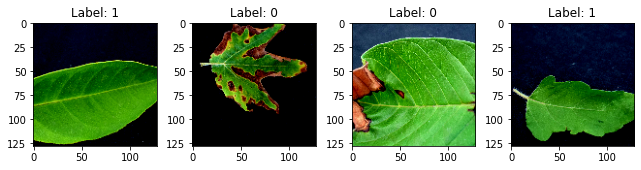

In [10]:
show_batch(a)

You can see that the original images changed to have different sizes and variations
in color and lighting. These changes followed the specified transformations you stated
in the pipeline. You are now ready to go to the next step: **Create the
architecture**.

## 2. Create Neural Network

Convolutional neural networks are a great tool to capture the spatial
relationship of pixel values within images, for this reason they have become the
gold standard for computer vision. In this example you will create a small convolutional neural
network using what you learned from [Step 2](2-create-nn.md) of this crash course series.
First, you can set up two functions that will generate the two types of blocks
you intend to use, the convolution block and the dense block. Then you can create an
entire network based on these two blocks using a custom class.

In [11]:
# The convolutional block has a convolution layer, a max pool layer and a batch normalization layer
def conv_block(filters, kernel_size=2, stride=2, batch_norm=True):
    conv_block = nn.HybridSequential()
    conv_block.add(nn.Conv2D(channels=filters, kernel_size=kernel_size, activation='relu'),
              nn.MaxPool2D(pool_size=4, strides=stride))
    if batch_norm:
        conv_block.add(nn.BatchNorm())
    return conv_block

# The dense block consists of a dense layer and a dropout layer
def dense_block(neurons, activation='relu', dropout=0.2):
    dense_block = nn.HybridSequential()
    dense_block.add(nn.Dense(neurons, activation=activation))
    if dropout:
        dense_block.add(nn.Dropout(dropout))
    return dense_block

In [12]:
# Create neural network blueprint using the blocks
class LeafNetwork(nn.HybridBlock):
    def __init__(self):
        super(LeafNetwork, self).__init__()
        self.conv1 = conv_block(32)
        self.conv2 = conv_block(64)
        self.conv3 = conv_block(128)
        self.flatten = nn.Flatten()
        self.dense1 = dense_block(100)
        self.dense2 = dense_block(10)
        self.dense3 = nn.Dense(2)

    def forward(self, batch):
        batch = self.conv1(batch)
        batch = self.conv2(batch)
        batch = self.conv3(batch)
        batch = self.flatten(batch)
        batch = self.dense1(batch)
        batch = self.dense2(batch)
        batch = self.dense3(batch)

        return batch

You have concluded the architecting part of the network, so now you can actually
build a model from that architecture for training. As you have seen
previously on [Step 4](4-components.md) of this
crash course series, to use the network you need to initialize the parameters and
hybridize the model.

In [13]:
# Create the model based on the blueprint provided and initialize the parameters
ctx = mx.gpu()

initializer = mx.initializer.Xavier()

model = LeafNetwork()
model.initialize(initializer, ctx=ctx)
model.summary(mx.np.random.uniform(size=(4, 3, 128, 128), ctx=ctx))
model.hybridize()

[15:13:30] /work/mxnet/src/storage/storage.cc:202: Using Pooled (Naive) StorageManager for GPU


--------------------------------------------------------------------------------
        Layer (type)                                Output Shape         Param #
               Input                            (4, 3, 128, 128)               0
        Activation-1                           (4, 32, 127, 127)               0
            Conv2D-2                           (4, 32, 127, 127)             416
         MaxPool2D-3                             (4, 32, 62, 62)               0
         BatchNorm-4                             (4, 32, 62, 62)             128
        Activation-5                             (4, 64, 61, 61)               0
            Conv2D-6                             (4, 64, 61, 61)            8256
         MaxPool2D-7                             (4, 64, 29, 29)               0
         BatchNorm-8                             (4, 64, 29, 29)             256
        Activation-9                            (4, 128, 28, 28)               0
           Conv2D-10        

[15:13:32] /work/mxnet/src/operator/nn/./cudnn/./cudnn_algoreg-inl.h:106: Running performance tests to find the best convolution algorithm, this can take a while... (set the environment variable MXNET_CUDNN_AUTOTUNE_DEFAULT to 0 to disable)


## 3. Choose Optimizer and Loss function

With the network created you can move on to choosing an optimizer and a loss
function. The network you created uses these components to make an informed decision on how
to tune the parameters to fit the final objective better. You can use the `gluon.Trainer` class to
help with optimizing these parameters. The `gluon.Trainer` class needs two things to work
properly: the parameters needing to be tuned and the optimizer with its
corresponding hyperparameters. The trainer uses the error reported by the loss
function to optimize these parameters.

For this particular dataset you will use Stochastic Gradient Descent as the
optimizer and Cross Entropy as the loss function.

In [14]:
# SGD optimizer
optimizer = 'sgd'

# Set parameters
optimizer_params = {'learning_rate': 0.001}

# Define the trainer for the model
trainer = gluon.Trainer(model.collect_params(), optimizer, optimizer_params)

# Define the loss function
loss_fn = gluon.loss.SoftmaxCrossEntropyLoss()

Finally, you have to set up the training loop, and you need to create a function to evaluate the performance of the network on the validation dataset.

In [15]:
# Function to return the accuracy for the validation and test set
def test(val_data):
    acc = gluon.metric.Accuracy()
    for batch in val_data:
        data = batch[0]
        labels = batch[1]
        outputs = model(data.as_in_ctx(ctx))
        acc.update([labels], [outputs])

    _, accuracy = acc.get()
    return accuracy

## 4. Training Loop

Now that you have everything set up, you can start training your network. This might
take some time to train depending on the hardware, number of layers, batch size and
images you use. For this particular case, you will only train for 2 epochs.

In [16]:
# Start the training loop
epochs = 2
accuracy = gluon.metric.Accuracy()
log_interval = 5

for epoch in range(epochs):
    tic = time.time()
    btic = time.time()
    accuracy.reset()

    for idx, batch in enumerate(train_loader):
        data = batch[0]
        label = batch[1]
        with mx.autograd.record():
            outputs = model(data.as_in_ctx(ctx))
            loss = loss_fn(outputs, label.as_in_ctx(ctx))
        mx.autograd.backward(loss)
        trainer.step(batch_size)
        accuracy.update([label], [outputs])
        if log_interval and (idx + 1) % log_interval == 0:
            _, acc = accuracy.get()

            print(f"""Epoch[{epoch + 1}] Batch[{idx + 1}] Speed: {batch_size / (time.time() - btic)} samples/sec \
                  batch loss = {loss.mean().item()} | accuracy = {acc}""")
            btic = time.time()

    _, acc = accuracy.get()

    acc_val = test(validation_loader)
    print(f"[Epoch {epoch + 1}] training: accuracy={acc}")
    print(f"[Epoch {epoch + 1}] time cost: {time.time() - tic}")
    print(f"[Epoch {epoch + 1}] validation: validation accuracy={acc_val}")

Epoch[1] Batch[5] Speed: 1.2839401186670796 samples/sec                   batch loss = 0.8778702616691589 | accuracy = 0.45


Epoch[1] Batch[10] Speed: 1.2831473684613062 samples/sec                   batch loss = 0.7562657594680786 | accuracy = 0.375


Epoch[1] Batch[15] Speed: 1.2831273488071437 samples/sec                   batch loss = 0.5728679299354553 | accuracy = 0.5


Epoch[1] Batch[20] Speed: 1.2841881707561733 samples/sec                   batch loss = 0.7963482141494751 | accuracy = 0.475


Epoch[1] Batch[25] Speed: 1.2840832971056644 samples/sec                   batch loss = 0.4684923589229584 | accuracy = 0.52


Epoch[1] Batch[30] Speed: 1.2808626904167937 samples/sec                   batch loss = 0.8282250761985779 | accuracy = 0.5333333333333333


Epoch[1] Batch[35] Speed: 1.285326369252956 samples/sec                   batch loss = 0.6315246820449829 | accuracy = 0.5428571428571428


Epoch[1] Batch[40] Speed: 1.2792326868145953 samples/sec                   batch loss = 1.1367919445037842 | accuracy = 0.55625


Epoch[1] Batch[45] Speed: 1.2873145102041208 samples/sec                   batch loss = 0.4699883460998535 | accuracy = 0.5722222222222222


Epoch[1] Batch[50] Speed: 1.279983203345415 samples/sec                   batch loss = 0.8151114583015442 | accuracy = 0.555


Epoch[1] Batch[55] Speed: 1.2825586199030476 samples/sec                   batch loss = 0.49230214953422546 | accuracy = 0.5636363636363636


Epoch[1] Batch[60] Speed: 1.2787617459046157 samples/sec                   batch loss = 0.6650543212890625 | accuracy = 0.5791666666666667


Epoch[1] Batch[65] Speed: 1.2832986155438453 samples/sec                   batch loss = 1.3225256204605103 | accuracy = 0.5807692307692308


Epoch[1] Batch[70] Speed: 1.283159537575968 samples/sec                   batch loss = 0.4943195879459381 | accuracy = 0.5964285714285714


Epoch[1] Batch[75] Speed: 1.2797506345275433 samples/sec                   batch loss = 0.70194011926651 | accuracy = 0.59


Epoch[1] Batch[80] Speed: 1.285167161885391 samples/sec                   batch loss = 1.0521340370178223 | accuracy = 0.59375


Epoch[1] Batch[85] Speed: 1.2806505257568732 samples/sec                   batch loss = 0.6800881624221802 | accuracy = 0.5941176470588235


Epoch[1] Batch[90] Speed: 1.2786756879833698 samples/sec                   batch loss = 0.8629487752914429 | accuracy = 0.6055555555555555


Epoch[1] Batch[95] Speed: 1.2769772722740498 samples/sec                   batch loss = 0.49469661712646484 | accuracy = 0.6052631578947368


Epoch[1] Batch[100] Speed: 1.2785569996874713 samples/sec                   batch loss = 0.31133562326431274 | accuracy = 0.6175


Epoch[1] Batch[105] Speed: 1.2826820730266908 samples/sec                   batch loss = 0.5928465127944946 | accuracy = 0.6214285714285714


Epoch[1] Batch[110] Speed: 1.2828889274278228 samples/sec                   batch loss = 0.5183454155921936 | accuracy = 0.6181818181818182


Epoch[1] Batch[115] Speed: 1.28986380914167 samples/sec                   batch loss = 0.3167092204093933 | accuracy = 0.6239130434782608


Epoch[1] Batch[120] Speed: 1.282228286430994 samples/sec                   batch loss = 0.41007134318351746 | accuracy = 0.6270833333333333


Epoch[1] Batch[125] Speed: 1.278327773437244 samples/sec                   batch loss = 0.367052286863327 | accuracy = 0.632


Epoch[1] Batch[130] Speed: 1.2797151024880173 samples/sec                   batch loss = 0.6887010931968689 | accuracy = 0.6346153846153846


Epoch[1] Batch[135] Speed: 1.2877644912704937 samples/sec                   batch loss = 0.33869487047195435 | accuracy = 0.6351851851851852


Epoch[1] Batch[140] Speed: 1.2824120563067727 samples/sec                   batch loss = 0.3858204185962677 | accuracy = 0.6410714285714286


Epoch[1] Batch[145] Speed: 1.282595976918921 samples/sec                   batch loss = 0.4166925847530365 | accuracy = 0.6413793103448275


Epoch[1] Batch[150] Speed: 1.2874739536790072 samples/sec                   batch loss = 0.11294819414615631 | accuracy = 0.6483333333333333


Epoch[1] Batch[155] Speed: 1.2863729794152303 samples/sec                   batch loss = 0.6667736172676086 | accuracy = 0.6483870967741936


Epoch[1] Batch[160] Speed: 1.2926128170961388 samples/sec                   batch loss = 0.5688076019287109 | accuracy = 0.6453125


Epoch[1] Batch[165] Speed: 1.2877600432783736 samples/sec                   batch loss = 0.6330973505973816 | accuracy = 0.6454545454545455


Epoch[1] Batch[170] Speed: 1.283718289555586 samples/sec                   batch loss = 0.5736441612243652 | accuracy = 0.6455882352941177


Epoch[1] Batch[175] Speed: 1.2854952686613743 samples/sec                   batch loss = 0.761870265007019 | accuracy = 0.6471428571428571


Epoch[1] Batch[180] Speed: 1.2842376157287803 samples/sec                   batch loss = 0.3284887373447418 | accuracy = 0.6486111111111111


Epoch[1] Batch[185] Speed: 1.285128768980147 samples/sec                   batch loss = 0.9211039543151855 | accuracy = 0.6459459459459459


Epoch[1] Batch[190] Speed: 1.284186991200941 samples/sec                   batch loss = 0.4820801913738251 | accuracy = 0.6447368421052632


Epoch[1] Batch[195] Speed: 1.2824563649782394 samples/sec                   batch loss = 0.7807456254959106 | accuracy = 0.6435897435897436


Epoch[1] Batch[200] Speed: 1.2789801101599585 samples/sec                   batch loss = 0.45867568254470825 | accuracy = 0.645


Epoch[1] Batch[205] Speed: 1.2806231547913558 samples/sec                   batch loss = 0.42071253061294556 | accuracy = 0.6475609756097561


Epoch[1] Batch[210] Speed: 1.280768723109795 samples/sec                   batch loss = 0.4185868501663208 | accuracy = 0.65


Epoch[1] Batch[215] Speed: 1.283846190518424 samples/sec                   batch loss = 0.549213707447052 | accuracy = 0.6511627906976745


Epoch[1] Batch[220] Speed: 1.2897675250297165 samples/sec                   batch loss = 1.6615067720413208 | accuracy = 0.6522727272727272


Epoch[1] Batch[225] Speed: 1.2889979673784837 samples/sec                   batch loss = 0.4198928773403168 | accuracy = 0.6533333333333333


Epoch[1] Batch[230] Speed: 1.284919715570519 samples/sec                   batch loss = 0.5492601990699768 | accuracy = 0.6554347826086957


Epoch[1] Batch[235] Speed: 1.2927047454759768 samples/sec                   batch loss = 0.3670082986354828 | accuracy = 0.6595744680851063


Epoch[1] Batch[240] Speed: 1.2861005193779975 samples/sec                   batch loss = 0.3454263508319855 | accuracy = 0.6583333333333333


Epoch[1] Batch[245] Speed: 1.2935518385169704 samples/sec                   batch loss = 0.5618530511856079 | accuracy = 0.6581632653061225


Epoch[1] Batch[250] Speed: 1.2888902273309737 samples/sec                   batch loss = 0.7914553880691528 | accuracy = 0.658


Epoch[1] Batch[255] Speed: 1.290388914535159 samples/sec                   batch loss = 0.5698132514953613 | accuracy = 0.6588235294117647


Epoch[1] Batch[260] Speed: 1.283777521625829 samples/sec                   batch loss = 0.31429046392440796 | accuracy = 0.6586538461538461


Epoch[1] Batch[265] Speed: 1.2822299523746017 samples/sec                   batch loss = 0.43931734561920166 | accuracy = 0.6613207547169812


Epoch[1] Batch[270] Speed: 1.2867839092186675 samples/sec                   batch loss = 0.7222689986228943 | accuracy = 0.6583333333333333


Epoch[1] Batch[275] Speed: 1.287650928828212 samples/sec                   batch loss = 0.4949851334095001 | accuracy = 0.6609090909090909


Epoch[1] Batch[280] Speed: 1.2872545562408753 samples/sec                   batch loss = 0.5363546013832092 | accuracy = 0.6625


Epoch[1] Batch[285] Speed: 1.2787802649785796 samples/sec                   batch loss = 0.38234537839889526 | accuracy = 0.6605263157894737


Epoch[1] Batch[290] Speed: 1.282486657402896 samples/sec                   batch loss = 1.631568193435669 | accuracy = 0.6612068965517242


Epoch[1] Batch[295] Speed: 1.2858667079929111 samples/sec                   batch loss = 0.42084643244743347 | accuracy = 0.6644067796610169


Epoch[1] Batch[300] Speed: 1.281365419831756 samples/sec                   batch loss = 1.1915256977081299 | accuracy = 0.6658333333333334


Epoch[1] Batch[305] Speed: 1.2878278537834877 samples/sec                   batch loss = 0.819495439529419 | accuracy = 0.6631147540983606


Epoch[1] Batch[310] Speed: 1.2841804053907173 samples/sec                   batch loss = 0.4532316029071808 | accuracy = 0.6661290322580645


Epoch[1] Batch[315] Speed: 1.2893586512761275 samples/sec                   batch loss = 0.40914857387542725 | accuracy = 0.6682539682539682


Epoch[1] Batch[320] Speed: 1.2865637602729378 samples/sec                   batch loss = 0.22223764657974243 | accuracy = 0.66953125


Epoch[1] Batch[325] Speed: 1.287346514276226 samples/sec                   batch loss = 0.9114986658096313 | accuracy = 0.6692307692307692


Epoch[1] Batch[330] Speed: 1.2888576513961882 samples/sec                   batch loss = 0.3490670919418335 | accuracy = 0.6704545454545454


Epoch[1] Batch[335] Speed: 1.2792131792715997 samples/sec                   batch loss = 0.19169776141643524 | accuracy = 0.6738805970149254


Epoch[1] Batch[340] Speed: 1.2876010230375312 samples/sec                   batch loss = 0.8484320044517517 | accuracy = 0.674264705882353


Epoch[1] Batch[345] Speed: 1.283878513612748 samples/sec                   batch loss = 0.8052343726158142 | accuracy = 0.6760869565217391


Epoch[1] Batch[350] Speed: 1.2840093945694686 samples/sec                   batch loss = 0.5761725902557373 | accuracy = 0.675


Epoch[1] Batch[355] Speed: 1.2863116337902516 samples/sec                   batch loss = 0.9821873307228088 | accuracy = 0.673943661971831


Epoch[1] Batch[360] Speed: 1.286689071144699 samples/sec                   batch loss = 0.34054070711135864 | accuracy = 0.675


Epoch[1] Batch[365] Speed: 1.2868976149093803 samples/sec                   batch loss = 0.6078773140907288 | accuracy = 0.6753424657534246


Epoch[1] Batch[370] Speed: 1.2871733754258237 samples/sec                   batch loss = 0.6708865165710449 | accuracy = 0.677027027027027


Epoch[1] Batch[375] Speed: 1.2843310112531579 samples/sec                   batch loss = 0.37886205315589905 | accuracy = 0.6786666666666666


Epoch[1] Batch[380] Speed: 1.2912007766345308 samples/sec                   batch loss = 0.45320746302604675 | accuracy = 0.6789473684210526


Epoch[1] Batch[385] Speed: 1.2844115389305966 samples/sec                   batch loss = 0.2901482582092285 | accuracy = 0.6805194805194805


Epoch[1] Batch[390] Speed: 1.2854328248748468 samples/sec                   batch loss = 0.20137855410575867 | accuracy = 0.6820512820512821


Epoch[1] Batch[395] Speed: 1.2854254383928505 samples/sec                   batch loss = 1.1236176490783691 | accuracy = 0.6816455696202531


Epoch[1] Batch[400] Speed: 1.280548574848005 samples/sec                   batch loss = 0.7067416310310364 | accuracy = 0.68


Epoch[1] Batch[405] Speed: 1.2834925112844444 samples/sec                   batch loss = 0.7347195148468018 | accuracy = 0.6796296296296296


Epoch[1] Batch[410] Speed: 1.2817047087239979 samples/sec                   batch loss = 0.5734509825706482 | accuracy = 0.6804878048780488


Epoch[1] Batch[415] Speed: 1.2836562147112898 samples/sec                   batch loss = 0.4337453842163086 | accuracy = 0.6819277108433734


Epoch[1] Batch[420] Speed: 1.2964232870695631 samples/sec                   batch loss = 0.47042974829673767 | accuracy = 0.6815476190476191


Epoch[1] Batch[425] Speed: 1.2849752202953162 samples/sec                   batch loss = 0.4918193519115448 | accuracy = 0.68


Epoch[1] Batch[430] Speed: 1.2881387268467013 samples/sec                   batch loss = 0.30445602536201477 | accuracy = 0.6825581395348838


Epoch[1] Batch[435] Speed: 1.2807564037568269 samples/sec                   batch loss = 0.6490077376365662 | accuracy = 0.6827586206896552


Epoch[1] Batch[440] Speed: 1.284056074038193 samples/sec                   batch loss = 0.5090688467025757 | accuracy = 0.6840909090909091


Epoch[1] Batch[445] Speed: 1.28987313092086 samples/sec                   batch loss = 0.4527672529220581 | accuracy = 0.6859550561797753


Epoch[1] Batch[450] Speed: 1.2930459808074894 samples/sec                   batch loss = 0.5445694327354431 | accuracy = 0.6877777777777778


Epoch[1] Batch[455] Speed: 1.2896280327718268 samples/sec                   batch loss = 0.6149773597717285 | accuracy = 0.6879120879120879


Epoch[1] Batch[460] Speed: 1.2873963015514933 samples/sec                   batch loss = 0.1853760927915573 | accuracy = 0.6875


Epoch[1] Batch[465] Speed: 1.2927024545774308 samples/sec                   batch loss = 0.5759531855583191 | accuracy = 0.6881720430107527


Epoch[1] Batch[470] Speed: 1.286507033062506 samples/sec                   batch loss = 0.3808845281600952 | accuracy = 0.6898936170212766


Epoch[1] Batch[475] Speed: 1.2860773513019517 samples/sec                   batch loss = 0.8580840826034546 | accuracy = 0.6889473684210526


Epoch[1] Batch[480] Speed: 1.28719559543404 samples/sec                   batch loss = 1.0094079971313477 | accuracy = 0.6890625


Epoch[1] Batch[485] Speed: 1.2886207580405844 samples/sec                   batch loss = 0.49807459115982056 | accuracy = 0.6876288659793814


Epoch[1] Batch[490] Speed: 1.292082119206114 samples/sec                   batch loss = 0.21386322379112244 | accuracy = 0.6877551020408164


Epoch[1] Batch[495] Speed: 1.2942778181674552 samples/sec                   batch loss = 0.7156855463981628 | accuracy = 0.6878787878787879


Epoch[1] Batch[500] Speed: 1.2937596199818011 samples/sec                   batch loss = 0.5441766977310181 | accuracy = 0.6875


Epoch[1] Batch[505] Speed: 1.296889383956486 samples/sec                   batch loss = 0.5248613357543945 | accuracy = 0.689108910891089


Epoch[1] Batch[510] Speed: 1.2954530853886943 samples/sec                   batch loss = 0.22657302021980286 | accuracy = 0.6892156862745098


Epoch[1] Batch[515] Speed: 1.2903521938550584 samples/sec                   batch loss = 0.19166728854179382 | accuracy = 0.6898058252427185


Epoch[1] Batch[520] Speed: 1.290340880336941 samples/sec                   batch loss = 0.5545787811279297 | accuracy = 0.6903846153846154


Epoch[1] Batch[525] Speed: 1.2968486835845126 samples/sec                   batch loss = 0.2789326608181 | accuracy = 0.69


Epoch[1] Batch[530] Speed: 1.2950422988700232 samples/sec                   batch loss = 0.5973058342933655 | accuracy = 0.6910377358490566


Epoch[1] Batch[535] Speed: 1.2970928238608197 samples/sec                   batch loss = 2.905303478240967 | accuracy = 0.6901869158878504


Epoch[1] Batch[540] Speed: 1.293669237316352 samples/sec                   batch loss = 0.605634331703186 | accuracy = 0.6902777777777778


Epoch[1] Batch[545] Speed: 1.294488030287096 samples/sec                   batch loss = 0.21034985780715942 | accuracy = 0.6912844036697248


Epoch[1] Batch[550] Speed: 1.2925107451043232 samples/sec                   batch loss = 0.5749714970588684 | accuracy = 0.6913636363636364


Epoch[1] Batch[555] Speed: 1.2912384400359576 samples/sec                   batch loss = 0.6642104983329773 | accuracy = 0.6918918918918919


Epoch[1] Batch[560] Speed: 1.291480671185649 samples/sec                   batch loss = 0.5059285759925842 | accuracy = 0.69375


Epoch[1] Batch[565] Speed: 1.290650485778218 samples/sec                   batch loss = 0.3635118305683136 | accuracy = 0.6946902654867256


Epoch[1] Batch[570] Speed: 1.2921758630479123 samples/sec                   batch loss = 1.4265613555908203 | accuracy = 0.6951754385964912


Epoch[1] Batch[575] Speed: 1.295872039902798 samples/sec                   batch loss = 0.2250889390707016 | accuracy = 0.6956521739130435


Epoch[1] Batch[580] Speed: 1.2956185535563063 samples/sec                   batch loss = 0.840876579284668 | accuracy = 0.6952586206896552


Epoch[1] Batch[585] Speed: 1.2878684841982329 samples/sec                   batch loss = 0.3257426917552948 | accuracy = 0.6948717948717948


Epoch[1] Batch[590] Speed: 1.2936714318893112 samples/sec                   batch loss = 0.5409936904907227 | accuracy = 0.6944915254237288


Epoch[1] Batch[595] Speed: 1.2964655636998643 samples/sec                   batch loss = 0.67755126953125 | accuracy = 0.6936974789915966


Epoch[1] Batch[600] Speed: 1.297308064362725 samples/sec                   batch loss = 0.9621434807777405 | accuracy = 0.6954166666666667


Epoch[1] Batch[605] Speed: 1.2879224643350173 samples/sec                   batch loss = 0.3748786747455597 | accuracy = 0.6962809917355371


Epoch[1] Batch[610] Speed: 1.2957941721138828 samples/sec                   batch loss = 0.42182084918022156 | accuracy = 0.6971311475409836


Epoch[1] Batch[615] Speed: 1.2931236183132373 samples/sec                   batch loss = 1.1643664836883545 | accuracy = 0.6979674796747968


Epoch[1] Batch[620] Speed: 1.2914326550826924 samples/sec                   batch loss = 0.42897629737854004 | accuracy = 0.6991935483870968


Epoch[1] Batch[625] Speed: 1.291651490322747 samples/sec                   batch loss = 0.5167430639266968 | accuracy = 0.6996


Epoch[1] Batch[630] Speed: 1.2935179294912662 samples/sec                   batch loss = 0.3312559723854065 | accuracy = 0.7


Epoch[1] Batch[635] Speed: 1.2890019287529242 samples/sec                   batch loss = 0.21723711490631104 | accuracy = 0.7003937007874016


Epoch[1] Batch[640] Speed: 1.292944637527788 samples/sec                   batch loss = 0.38106703758239746 | accuracy = 0.700390625


Epoch[1] Batch[645] Speed: 1.287024471791306 samples/sec                   batch loss = 1.1593003273010254 | accuracy = 0.6988372093023256


Epoch[1] Batch[650] Speed: 1.2895781718587336 samples/sec                   batch loss = 0.22923125326633453 | accuracy = 0.7003846153846154


Epoch[1] Batch[655] Speed: 1.2893296187100938 samples/sec                   batch loss = 0.8609527945518494 | accuracy = 0.7


Epoch[1] Batch[660] Speed: 1.2832818303645186 samples/sec                   batch loss = 0.4303414821624756 | accuracy = 0.7003787878787879


Epoch[1] Batch[665] Speed: 1.2890158927920146 samples/sec                   batch loss = 0.7766333222389221 | accuracy = 0.6996240601503759


Epoch[1] Batch[670] Speed: 1.2883748493606857 samples/sec                   batch loss = 0.34292927384376526 | accuracy = 0.7


Epoch[1] Batch[675] Speed: 1.2849044624524304 samples/sec                   batch loss = 0.1459474414587021 | accuracy = 0.7018518518518518


Epoch[1] Batch[680] Speed: 1.2895731165937567 samples/sec                   batch loss = 0.22281520068645477 | accuracy = 0.7029411764705882


Epoch[1] Batch[685] Speed: 1.287613177952957 samples/sec                   batch loss = 0.2697563171386719 | accuracy = 0.7032846715328467


Epoch[1] Batch[690] Speed: 1.287626617801391 samples/sec                   batch loss = 0.5205193161964417 | accuracy = 0.7036231884057971


Epoch[1] Batch[695] Speed: 1.2879625074695797 samples/sec                   batch loss = 0.5628350973129272 | accuracy = 0.7025179856115108


Epoch[1] Batch[700] Speed: 1.2907272400795613 samples/sec                   batch loss = 0.309465229511261 | accuracy = 0.7032142857142857


Epoch[1] Batch[705] Speed: 1.2907918875886075 samples/sec                   batch loss = 0.3950755298137665 | accuracy = 0.7039007092198581


Epoch[1] Batch[710] Speed: 1.2968237232901194 samples/sec                   batch loss = 0.44204914569854736 | accuracy = 0.7028169014084507


Epoch[1] Batch[715] Speed: 1.2934846205910817 samples/sec                   batch loss = 0.6119598746299744 | accuracy = 0.7034965034965035


Epoch[1] Batch[720] Speed: 1.2914447830366829 samples/sec                   batch loss = 0.42195120453834534 | accuracy = 0.703125


Epoch[1] Batch[725] Speed: 1.289452991370222 samples/sec                   batch loss = 0.4890383780002594 | accuracy = 0.7034482758620689


Epoch[1] Batch[730] Speed: 1.2889598403944533 samples/sec                   batch loss = 0.6647154092788696 | accuracy = 0.7027397260273973


Epoch[1] Batch[735] Speed: 1.2933608741055018 samples/sec                   batch loss = 0.40910103917121887 | accuracy = 0.7034013605442176


Epoch[1] Batch[740] Speed: 1.301238444744963 samples/sec                   batch loss = 0.7760217189788818 | accuracy = 0.7047297297297297


Epoch[1] Batch[745] Speed: 1.290795859996961 samples/sec                   batch loss = 0.6577196717262268 | accuracy = 0.7040268456375839


Epoch[1] Batch[750] Speed: 1.2960305067300484 samples/sec                   batch loss = 0.47755372524261475 | accuracy = 0.7043333333333334


Epoch[1] Batch[755] Speed: 1.295952219474025 samples/sec                   batch loss = 0.1139615923166275 | accuracy = 0.7039735099337748


Epoch[1] Batch[760] Speed: 1.2894302969563474 samples/sec                   batch loss = 0.604092001914978 | accuracy = 0.7042763157894737


Epoch[1] Batch[765] Speed: 1.2964449259481923 samples/sec                   batch loss = 0.31245285272598267 | accuracy = 0.7049019607843138


Epoch[1] Batch[770] Speed: 1.2908455171644388 samples/sec                   batch loss = 0.3446598947048187 | accuracy = 0.7051948051948052


Epoch[1] Batch[775] Speed: 1.2876840367841393 samples/sec                   batch loss = 0.7180768847465515 | accuracy = 0.7054838709677419


Epoch[1] Batch[780] Speed: 1.28998678812803 samples/sec                   batch loss = 0.7951799631118774 | accuracy = 0.7057692307692308


Epoch[1] Batch[785] Speed: 1.2876579455960968 samples/sec                   batch loss = 0.4272530972957611 | accuracy = 0.7060509554140127


[Epoch 1] training: accuracy=0.7065355329949239
[Epoch 1] time cost: 638.7018148899078
[Epoch 1] validation: validation accuracy=0.7711111111111111


Epoch[2] Batch[5] Speed: 1.2848495542256662 samples/sec                   batch loss = 0.17765042185783386 | accuracy = 0.75


Epoch[2] Batch[10] Speed: 1.2803199041508555 samples/sec                   batch loss = 0.504360020160675 | accuracy = 0.725


Epoch[2] Batch[15] Speed: 1.284689481218636 samples/sec                   batch loss = 0.1860484480857849 | accuracy = 0.75


Epoch[2] Batch[20] Speed: 1.2839485689442118 samples/sec                   batch loss = 0.19615717232227325 | accuracy = 0.75


Epoch[2] Batch[25] Speed: 1.2848379434096557 samples/sec                   batch loss = 1.090981364250183 | accuracy = 0.72


Epoch[2] Batch[30] Speed: 1.2839064169240517 samples/sec                   batch loss = 0.8896669745445251 | accuracy = 0.7166666666666667


Epoch[2] Batch[35] Speed: 1.2821756644403701 samples/sec                   batch loss = 0.5500986576080322 | accuracy = 0.7142857142857143


Epoch[2] Batch[40] Speed: 1.278685433485701 samples/sec                   batch loss = 0.7978625893592834 | accuracy = 0.70625


Epoch[2] Batch[45] Speed: 1.2825825438306258 samples/sec                   batch loss = 0.2594672739505768 | accuracy = 0.7111111111111111


Epoch[2] Batch[50] Speed: 1.2833675277237704 samples/sec                   batch loss = 0.5223470330238342 | accuracy = 0.705


Epoch[2] Batch[55] Speed: 1.286342207244949 samples/sec                   batch loss = 0.5956896543502808 | accuracy = 0.7045454545454546


Epoch[2] Batch[60] Speed: 1.2794380397952956 samples/sec                   batch loss = 0.4299306273460388 | accuracy = 0.7041666666666667


Epoch[2] Batch[65] Speed: 1.2914868350019602 samples/sec                   batch loss = 0.4779297113418579 | accuracy = 0.7038461538461539


Epoch[2] Batch[70] Speed: 1.2875318530911073 samples/sec                   batch loss = 0.42525866627693176 | accuracy = 0.7


Epoch[2] Batch[75] Speed: 1.284451167367873 samples/sec                   batch loss = 0.34484314918518066 | accuracy = 0.7033333333333334


Epoch[2] Batch[80] Speed: 1.2880010698785131 samples/sec                   batch loss = 0.33192580938339233 | accuracy = 0.709375


Epoch[2] Batch[85] Speed: 1.2813003431063843 samples/sec                   batch loss = 0.8949266672134399 | accuracy = 0.711764705882353


Epoch[2] Batch[90] Speed: 1.28312882081926 samples/sec                   batch loss = 0.40941473841667175 | accuracy = 0.7138888888888889


Epoch[2] Batch[95] Speed: 1.2827159066651743 samples/sec                   batch loss = 0.35471397638320923 | accuracy = 0.7157894736842105


Epoch[2] Batch[100] Speed: 1.2845123356615602 samples/sec                   batch loss = 0.42343124747276306 | accuracy = 0.7225


Epoch[2] Batch[105] Speed: 1.2810472428288964 samples/sec                   batch loss = 0.7181757688522339 | accuracy = 0.7285714285714285


Epoch[2] Batch[110] Speed: 1.2810955658109417 samples/sec                   batch loss = 0.6971927881240845 | accuracy = 0.7318181818181818


Epoch[2] Batch[115] Speed: 1.2761651370047602 samples/sec                   batch loss = 0.27064505219459534 | accuracy = 0.7369565217391304


Epoch[2] Batch[120] Speed: 1.279008190974955 samples/sec                   batch loss = 0.5830037593841553 | accuracy = 0.7333333333333333


Epoch[2] Batch[125] Speed: 1.279327209285461 samples/sec                   batch loss = 0.34352269768714905 | accuracy = 0.742


Epoch[2] Batch[130] Speed: 1.2794141354643969 samples/sec                   batch loss = 0.25891751050949097 | accuracy = 0.7423076923076923


Epoch[2] Batch[135] Speed: 1.2774212215026124 samples/sec                   batch loss = 0.34301915764808655 | accuracy = 0.7425925925925926


Epoch[2] Batch[140] Speed: 1.282978202422096 samples/sec                   batch loss = 0.10004091262817383 | accuracy = 0.7482142857142857


Epoch[2] Batch[145] Speed: 1.2870425398253489 samples/sec                   batch loss = 0.5454647541046143 | accuracy = 0.746551724137931


Epoch[2] Batch[150] Speed: 1.276456807858253 samples/sec                   batch loss = 0.6161813735961914 | accuracy = 0.745


Epoch[2] Batch[155] Speed: 1.2842411546799835 samples/sec                   batch loss = 1.3045912981033325 | accuracy = 0.7403225806451613


Epoch[2] Batch[160] Speed: 1.2924227271809863 samples/sec                   batch loss = 0.3070221543312073 | accuracy = 0.7453125


Epoch[2] Batch[165] Speed: 1.2930648162649228 samples/sec                   batch loss = 0.644496500492096 | accuracy = 0.746969696969697


Epoch[2] Batch[170] Speed: 1.2925656130200676 samples/sec                   batch loss = 0.37677472829818726 | accuracy = 0.7485294117647059


Epoch[2] Batch[175] Speed: 1.2883295371987022 samples/sec                   batch loss = 0.508232831954956 | accuracy = 0.7514285714285714


Epoch[2] Batch[180] Speed: 1.2867131494147934 samples/sec                   batch loss = 0.4616967439651489 | accuracy = 0.7486111111111111


Epoch[2] Batch[185] Speed: 1.294207030499987 samples/sec                   batch loss = 0.3851669132709503 | accuracy = 0.7513513513513513


Epoch[2] Batch[190] Speed: 1.2865997723153397 samples/sec                   batch loss = 0.5095594525337219 | accuracy = 0.7486842105263158


Epoch[2] Batch[195] Speed: 1.2847685780757758 samples/sec                   batch loss = 0.312524676322937 | accuracy = 0.7487179487179487


Epoch[2] Batch[200] Speed: 1.2836645630355579 samples/sec                   batch loss = 0.2532612383365631 | accuracy = 0.75125


Epoch[2] Batch[205] Speed: 1.2862791880682791 samples/sec                   batch loss = 0.5390929579734802 | accuracy = 0.75


Epoch[2] Batch[210] Speed: 1.2904566051575141 samples/sec                   batch loss = 0.5768648982048035 | accuracy = 0.7523809523809524


Epoch[2] Batch[215] Speed: 1.2881721566136735 samples/sec                   batch loss = 1.2015374898910522 | accuracy = 0.7523255813953489


Epoch[2] Batch[220] Speed: 1.283459618513619 samples/sec                   batch loss = 0.646869957447052 | accuracy = 0.7522727272727273


Epoch[2] Batch[225] Speed: 1.287924046238772 samples/sec                   batch loss = 0.6376695036888123 | accuracy = 0.7533333333333333


Epoch[2] Batch[230] Speed: 1.2854504542882939 samples/sec                   batch loss = 0.5531057119369507 | accuracy = 0.7532608695652174


Epoch[2] Batch[235] Speed: 1.2933524988895213 samples/sec                   batch loss = 0.662437379360199 | accuracy = 0.75


Epoch[2] Batch[240] Speed: 1.287486007393606 samples/sec                   batch loss = 0.48110073804855347 | accuracy = 0.7520833333333333


Epoch[2] Batch[245] Speed: 1.2934344610232318 samples/sec                   batch loss = 0.7120676040649414 | accuracy = 0.7489795918367347


Epoch[2] Batch[250] Speed: 1.2882281405234022 samples/sec                   batch loss = 0.4098200798034668 | accuracy = 0.749


Epoch[2] Batch[255] Speed: 1.2903757146987338 samples/sec                   batch loss = 0.4238322079181671 | accuracy = 0.7470588235294118


Epoch[2] Batch[260] Speed: 1.2900851882026048 samples/sec                   batch loss = 0.5386909246444702 | accuracy = 0.7471153846153846


Epoch[2] Batch[265] Speed: 1.2840179440288042 samples/sec                   batch loss = 0.2260666936635971 | accuracy = 0.7490566037735849


Epoch[2] Batch[270] Speed: 1.2891765505208623 samples/sec                   batch loss = 0.3151306211948395 | accuracy = 0.7509259259259259


Epoch[2] Batch[275] Speed: 1.2848022267065875 samples/sec                   batch loss = 0.4775124192237854 | accuracy = 0.75


Epoch[2] Batch[280] Speed: 1.284834105982707 samples/sec                   batch loss = 0.6928771734237671 | accuracy = 0.7517857142857143


Epoch[2] Batch[285] Speed: 1.2811459468903612 samples/sec                   batch loss = 0.302947998046875 | accuracy = 0.7508771929824561


Epoch[2] Batch[290] Speed: 1.2891720927687882 samples/sec                   batch loss = 0.4029451012611389 | accuracy = 0.75


Epoch[2] Batch[295] Speed: 1.2932896882269216 samples/sec                   batch loss = 0.33088919520378113 | accuracy = 0.7491525423728813


Epoch[2] Batch[300] Speed: 1.2777716595006663 samples/sec                   batch loss = 0.3889425992965698 | accuracy = 0.7491666666666666


Epoch[2] Batch[305] Speed: 1.2890460997272577 samples/sec                   batch loss = 0.5534094572067261 | accuracy = 0.7491803278688525


Epoch[2] Batch[310] Speed: 1.289630411917732 samples/sec                   batch loss = 0.15450912714004517 | accuracy = 0.7516129032258064


Epoch[2] Batch[315] Speed: 1.283899735739078 samples/sec                   batch loss = 0.24218566715717316 | accuracy = 0.7507936507936508


Epoch[2] Batch[320] Speed: 1.2874213942171375 samples/sec                   batch loss = 0.3528217375278473 | accuracy = 0.7515625


Epoch[2] Batch[325] Speed: 1.2865490600460305 samples/sec                   batch loss = 1.2092807292938232 | accuracy = 0.75


Epoch[2] Batch[330] Speed: 1.2897727801252856 samples/sec                   batch loss = 1.4733184576034546 | accuracy = 0.7484848484848485


Epoch[2] Batch[335] Speed: 1.2829411174543204 samples/sec                   batch loss = 0.31277957558631897 | accuracy = 0.7514925373134328


Epoch[2] Batch[340] Speed: 1.2911411556892094 samples/sec                   batch loss = 0.46252235770225525 | accuracy = 0.7522058823529412


Epoch[2] Batch[345] Speed: 1.2889346877229648 samples/sec                   batch loss = 0.3925536870956421 | accuracy = 0.7514492753623189


Epoch[2] Batch[350] Speed: 1.282999885367344 samples/sec                   batch loss = 0.37994682788848877 | accuracy = 0.7535714285714286


Epoch[2] Batch[355] Speed: 1.2801561713957261 samples/sec                   batch loss = 0.6630321741104126 | accuracy = 0.7528169014084507


Epoch[2] Batch[360] Speed: 1.2826673633057881 samples/sec                   batch loss = 0.1057804748415947 | accuracy = 0.7555555555555555


Epoch[2] Batch[365] Speed: 1.282601762058228 samples/sec                   batch loss = 0.5209928154945374 | accuracy = 0.7561643835616438


Epoch[2] Batch[370] Speed: 1.289948205905591 samples/sec                   batch loss = 0.5792557001113892 | accuracy = 0.7547297297297297


Epoch[2] Batch[375] Speed: 1.2854622731602428 samples/sec                   batch loss = 0.16619859635829926 | accuracy = 0.7553333333333333


Epoch[2] Batch[380] Speed: 1.2890933442317447 samples/sec                   batch loss = 0.4882088899612427 | accuracy = 0.7539473684210526


Epoch[2] Batch[385] Speed: 1.29088236525199 samples/sec                   batch loss = 0.3200864791870117 | accuracy = 0.7532467532467533


Epoch[2] Batch[390] Speed: 1.2829144333012372 samples/sec                   batch loss = 0.08815906196832657 | accuracy = 0.7557692307692307


Epoch[2] Batch[395] Speed: 1.2880402279180756 samples/sec                   batch loss = 0.3307943344116211 | accuracy = 0.7569620253164557


Epoch[2] Batch[400] Speed: 1.2847705457834422 samples/sec                   batch loss = 0.6811748147010803 | accuracy = 0.756875


Epoch[2] Batch[405] Speed: 1.2879547952648829 samples/sec                   batch loss = 0.2174670249223709 | accuracy = 0.7549382716049383


Epoch[2] Batch[410] Speed: 1.283071611100243 samples/sec                   batch loss = 0.6333861947059631 | accuracy = 0.7548780487804878


Epoch[2] Batch[415] Speed: 1.2847733989702648 samples/sec                   batch loss = 0.4591231942176819 | accuracy = 0.7560240963855421


Epoch[2] Batch[420] Speed: 1.2879436226193366 samples/sec                   batch loss = 0.33918899297714233 | accuracy = 0.7571428571428571


Epoch[2] Batch[425] Speed: 1.2812042569309532 samples/sec                   batch loss = 0.25919070839881897 | accuracy = 0.7576470588235295


Epoch[2] Batch[430] Speed: 1.2895393167228275 samples/sec                   batch loss = 1.5180491209030151 | accuracy = 0.7575581395348837


Epoch[2] Batch[435] Speed: 1.2881409026959012 samples/sec                   batch loss = 0.226614311337471 | accuracy = 0.7580459770114942


Epoch[2] Batch[440] Speed: 1.2870802572470308 samples/sec                   batch loss = 0.20723874866962433 | accuracy = 0.7568181818181818


Epoch[2] Batch[445] Speed: 1.286663612314693 samples/sec                   batch loss = 0.3997948169708252 | accuracy = 0.7567415730337078


Epoch[2] Batch[450] Speed: 1.2833336597019602 samples/sec                   batch loss = 0.21981649100780487 | accuracy = 0.7577777777777778


Epoch[2] Batch[455] Speed: 1.2786079608458503 samples/sec                   batch loss = 0.431056410074234 | accuracy = 0.7582417582417582


Epoch[2] Batch[460] Speed: 1.2859586649748675 samples/sec                   batch loss = 0.09203346818685532 | accuracy = 0.7603260869565217


Epoch[2] Batch[465] Speed: 1.2923500517333921 samples/sec                   batch loss = 0.48246386647224426 | accuracy = 0.7596774193548387


Epoch[2] Batch[470] Speed: 1.2812967224902216 samples/sec                   batch loss = 0.292100727558136 | accuracy = 0.7595744680851064


Epoch[2] Batch[475] Speed: 1.2824356806819837 samples/sec                   batch loss = 0.43365007638931274 | accuracy = 0.7578947368421053


Epoch[2] Batch[480] Speed: 1.288661042573811 samples/sec                   batch loss = 0.8566080331802368 | accuracy = 0.7588541666666667


Epoch[2] Batch[485] Speed: 1.2823820614662567 samples/sec                   batch loss = 0.9952598810195923 | accuracy = 0.7572164948453608


Epoch[2] Batch[490] Speed: 1.2848984597117108 samples/sec                   batch loss = 0.664642333984375 | accuracy = 0.7561224489795918


Epoch[2] Batch[495] Speed: 1.288072169193245 samples/sec                   batch loss = 0.389474481344223 | accuracy = 0.7565656565656566


Epoch[2] Batch[500] Speed: 1.2836106445965294 samples/sec                   batch loss = 0.217572882771492 | accuracy = 0.757


Epoch[2] Batch[505] Speed: 1.283249537307187 samples/sec                   batch loss = 0.5164052844047546 | accuracy = 0.7579207920792079


Epoch[2] Batch[510] Speed: 1.2801171982298185 samples/sec                   batch loss = 0.8088529109954834 | accuracy = 0.7578431372549019


Epoch[2] Batch[515] Speed: 1.2873795077941204 samples/sec                   batch loss = 0.16382931172847748 | accuracy = 0.7592233009708738


Epoch[2] Batch[520] Speed: 1.2881358586930776 samples/sec                   batch loss = 0.12817704677581787 | accuracy = 0.7600961538461538


Epoch[2] Batch[525] Speed: 1.285358471496545 samples/sec                   batch loss = 0.43724244832992554 | accuracy = 0.7609523809523809


Epoch[2] Batch[530] Speed: 1.2813567099319791 samples/sec                   batch loss = 0.28304192423820496 | accuracy = 0.7608490566037736


Epoch[2] Batch[535] Speed: 1.287680182337526 samples/sec                   batch loss = 0.8999611139297485 | accuracy = 0.7598130841121495


Epoch[2] Batch[540] Speed: 1.2822914973252755 samples/sec                   batch loss = 1.211863398551941 | accuracy = 0.7597222222222222


Epoch[2] Batch[545] Speed: 1.2838274261860387 samples/sec                   batch loss = 0.4634430706501007 | accuracy = 0.7591743119266054


Epoch[2] Batch[550] Speed: 1.2799494160615905 samples/sec                   batch loss = 0.7121054530143738 | accuracy = 0.7581818181818182


Epoch[2] Batch[555] Speed: 1.2827144356002995 samples/sec                   batch loss = 0.46885794401168823 | accuracy = 0.7576576576576577


Epoch[2] Batch[560] Speed: 1.278029405648182 samples/sec                   batch loss = 0.358233779668808 | accuracy = 0.7584821428571429


Epoch[2] Batch[565] Speed: 1.283131568584247 samples/sec                   batch loss = 0.2785889804363251 | accuracy = 0.7575221238938054


Epoch[2] Batch[570] Speed: 1.283685974528301 samples/sec                   batch loss = 0.4014786183834076 | accuracy = 0.7570175438596491


Epoch[2] Batch[575] Speed: 1.2867176888617562 samples/sec                   batch loss = 0.22942017018795013 | accuracy = 0.7565217391304347


Epoch[2] Batch[580] Speed: 1.2858573454795228 samples/sec                   batch loss = 0.38808220624923706 | accuracy = 0.756896551724138


Epoch[2] Batch[585] Speed: 1.2822674862515517 samples/sec                   batch loss = 0.23989564180374146 | accuracy = 0.7576923076923077


Epoch[2] Batch[590] Speed: 1.2901259611802967 samples/sec                   batch loss = 0.12338466197252274 | accuracy = 0.7584745762711864


Epoch[2] Batch[595] Speed: 1.2840009434916753 samples/sec                   batch loss = 0.5464639067649841 | accuracy = 0.7579831932773109


Epoch[2] Batch[600] Speed: 1.2867067350334742 samples/sec                   batch loss = 0.3542753756046295 | accuracy = 0.7579166666666667


Epoch[2] Batch[605] Speed: 1.2877919706586476 samples/sec                   batch loss = 0.44311004877090454 | accuracy = 0.7574380165289256


Epoch[2] Batch[610] Speed: 1.2827919162746864 samples/sec                   batch loss = 0.2828121483325958 | accuracy = 0.7573770491803279


Epoch[2] Batch[615] Speed: 1.2861117586602533 samples/sec                   batch loss = 0.42763909697532654 | accuracy = 0.7569105691056911


Epoch[2] Batch[620] Speed: 1.2769592913480938 samples/sec                   batch loss = 0.09370920062065125 | accuracy = 0.7564516129032258


Epoch[2] Batch[625] Speed: 1.2830525750350872 samples/sec                   batch loss = 0.23343545198440552 | accuracy = 0.7568


Epoch[2] Batch[630] Speed: 1.2858420700924742 samples/sec                   batch loss = 0.659576416015625 | accuracy = 0.7571428571428571


Epoch[2] Batch[635] Speed: 1.284359524172243 samples/sec                   batch loss = 0.5463717579841614 | accuracy = 0.7566929133858268


Epoch[2] Batch[640] Speed: 1.277780223412544 samples/sec                   batch loss = 0.6730369925498962 | accuracy = 0.755859375


Epoch[2] Batch[645] Speed: 1.280285708289852 samples/sec                   batch loss = 0.33939510583877563 | accuracy = 0.756201550387597


Epoch[2] Batch[650] Speed: 1.2791763116401487 samples/sec                   batch loss = 2.027479410171509 | accuracy = 0.7565384615384615


Epoch[2] Batch[655] Speed: 1.279469848575774 samples/sec                   batch loss = 0.4594833254814148 | accuracy = 0.7572519083969466


Epoch[2] Batch[660] Speed: 1.2818213379362278 samples/sec                   batch loss = 0.317995548248291 | accuracy = 0.7583333333333333


Epoch[2] Batch[665] Speed: 1.2745221761876409 samples/sec                   batch loss = 0.7010849714279175 | accuracy = 0.7560150375939849


Epoch[2] Batch[670] Speed: 1.2833902055723372 samples/sec                   batch loss = 0.2573395371437073 | accuracy = 0.7574626865671642


Epoch[2] Batch[675] Speed: 1.2906198064702938 samples/sec                   batch loss = 0.1005997434258461 | accuracy = 0.7577777777777778


Epoch[2] Batch[680] Speed: 1.2860457060447203 samples/sec                   batch loss = 0.20394571125507355 | accuracy = 0.7584558823529411


Epoch[2] Batch[685] Speed: 1.2933674547084384 samples/sec                   batch loss = 0.3762814998626709 | accuracy = 0.7591240875912408


Epoch[2] Batch[690] Speed: 1.2898189871487957 samples/sec                   batch loss = 0.1925601065158844 | accuracy = 0.7590579710144928


Epoch[2] Batch[695] Speed: 1.2943085717812426 samples/sec                   batch loss = 0.1488758772611618 | accuracy = 0.7597122302158273


Epoch[2] Batch[700] Speed: 1.2893213947054813 samples/sec                   batch loss = 0.5866915583610535 | accuracy = 0.7596428571428572


Epoch[2] Batch[705] Speed: 1.303680431221505 samples/sec                   batch loss = 0.6760915517807007 | accuracy = 0.7599290780141844


Epoch[2] Batch[710] Speed: 1.28942990055447 samples/sec                   batch loss = 0.7559224367141724 | accuracy = 0.7591549295774648


Epoch[2] Batch[715] Speed: 1.2900442194121897 samples/sec                   batch loss = 0.16977007687091827 | accuracy = 0.7594405594405594


Epoch[2] Batch[720] Speed: 1.2908921983856554 samples/sec                   batch loss = 0.24620945751667023 | accuracy = 0.7597222222222222


Epoch[2] Batch[725] Speed: 1.2870316791976182 samples/sec                   batch loss = 0.41088151931762695 | accuracy = 0.7586206896551724


Epoch[2] Batch[730] Speed: 1.291479378780013 samples/sec                   batch loss = 0.2671608626842499 | accuracy = 0.7578767123287671


Epoch[2] Batch[735] Speed: 1.2944215139853512 samples/sec                   batch loss = 0.5195905566215515 | accuracy = 0.7591836734693878


Epoch[2] Batch[740] Speed: 1.2904348679519162 samples/sec                   batch loss = 0.5072628855705261 | accuracy = 0.7584459459459459


Epoch[2] Batch[745] Speed: 1.2927552469106074 samples/sec                   batch loss = 0.14865891635417938 | accuracy = 0.7590604026845638


Epoch[2] Batch[750] Speed: 1.2833669386994215 samples/sec                   batch loss = 0.5956651568412781 | accuracy = 0.758


Epoch[2] Batch[755] Speed: 1.2898254325975906 samples/sec                   batch loss = 0.5084124803543091 | accuracy = 0.7576158940397351


Epoch[2] Batch[760] Speed: 1.2895637000293774 samples/sec                   batch loss = 0.3592997193336487 | accuracy = 0.7575657894736842


Epoch[2] Batch[765] Speed: 1.287036023426715 samples/sec                   batch loss = 0.6266438961029053 | accuracy = 0.7578431372549019


Epoch[2] Batch[770] Speed: 1.2890123274766763 samples/sec                   batch loss = 0.4601980745792389 | accuracy = 0.7584415584415585


Epoch[2] Batch[775] Speed: 1.2847999637316905 samples/sec                   batch loss = 2.374311685562134 | accuracy = 0.7583870967741936


Epoch[2] Batch[780] Speed: 1.2831562989987195 samples/sec                   batch loss = 0.17673994600772858 | accuracy = 0.7592948717948718


Epoch[2] Batch[785] Speed: 1.2821128568808462 samples/sec                   batch loss = 0.3228895962238312 | accuracy = 0.7598726114649682


[Epoch 2] training: accuracy=0.7598350253807107
[Epoch 2] time cost: 630.5346415042877
[Epoch 2] validation: validation accuracy=0.7677777777777778


## 5. Test on the test set

Now that your network is trained and has reached a decent accuracy, you can
evaluate the performance on the test set. For that, you can use the `test_loader` data
loader and the test function you created previously.

In [17]:
test(test_loader)

0.7511111111111111

You have a trained network that can confidently discriminate between plants that
are healthy and the ones that are diseased. You can now start your garden and
set cameras to automatically detect plants in distress! Or change your classification
problem to create a model that classify the species of the plants! Either way you
might be able to impress your botanist friends.

## 6. Save the parameters

If you want to preserve the trained weights of the network you can save the
parameters in a file. Later, when you want to use the network to make predictions
you can load the parameters back!

In [18]:
# Save parameters in the
model.save_parameters('leaf_models.params')

This is the end of this tutorial, to see how you can speed up the training by
using GPU hardware continue to the [next tutorial](./7-use-gpus.ipynb)